<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Image Segmentation Model

In this notebook, we show how to train and evaluate an image segmentation model using a Unet CNN in [fast.ai](https://www.fast.ai/). 

We distinguish between semantic and instance segmentation. Instance segmentation aims to find and segment different objects in an image - we showed how to sole such problems in the [02_mask_rcnn.ipynb](../detection/02_mask_rcnn.ipynb) notebook. 

In this notebook, we are interested in semantic segmentation, which classifies pixels in an image by object class. Using a small dataset of four different beverage packages, we demonstrate how to train and evaluate such models.

<img src="../detection/media/segmentaion_comparison.png" width="1000"/>



## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import all the functions we need.

In [2]:
import sys
sys.path.append("../../")

from pathlib import Path
import fastai
from fastai.vision import *
import numpy as np
import scrapbook as sb
import urllib

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor
from utils_cv.segmentation.data import Urls
from utils_cv.segmentation.dataset import read_classes
from utils_cv.segmentation.model import get_objective_fct, predict, confusion_matrix, print_accuracies
from utils_cv.segmentation.plot import plot_image_and_mask, plot_segmentation, plot_mask_stats, plot_confusion_matrix
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla K80


This shows your machine's GPUs (if has any) and the computing device `fastai/torch` is using. We suggest using an  [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6 as a GPU compute resource.

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# Training params
EPOCHS_HEAD = 3 # 10
EPOCHS_FULL = 15 # 24
LEARNING_RATE = 3e-3

# Model and inference params
IM_SIZE = [133, 100] # down-scale to speed up processing, at same aspect ratio as the original image
BATCH_SIZE = 8 
ARCHITECTURE = models.resnet18  #models.resnet34, 
THRESHOLD = None

---

# Prepare Dataset

In this notebook, we use a toy dataset specified in DATA_PATH which consists of 129 images of 4 classes of beverage containers `{can, carton, milk bottle, water bottle}`. For each image, a mask is provided with ground truth pixel-weise annotation. 

In [4]:
DATA_PATH = Path(DATA_PATH)
DATA_PATH.ls()

[WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/classes.txt'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks')]

You'll notice that `DATA_PATH` contains two subfolders and one file:
- `/images`
- `/segmentation-masks`
- `classes.txt`

This is a common data format for image segmentation. The two folders use the same filename to indicate which mask corresponds to which image. 

In [5]:
im_path = DATA_PATH / "images"
im_paths = sorted(get_image_files(im_path))
im_paths[:3]

[WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images/1.jpg'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images/10.jpg'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/images/100.jpg')]

In [6]:
anno_path = DATA_PATH / "segmentation-masks"
mask_paths = sorted(get_image_files(anno_path))
mask_paths[:3]

[WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks/1.png'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks/10.png'),
 WindowsPath('C:/Users/pabuehle/Desktop/computervision-recipes/data/segFridgeObjects/segmentation-masks/100.png')]

The masks in `segmentation-masks` contain at each pixel the id of the object. In our case, id 0 corresponds to "background", 1 to "can", 2 to "carton", 3 to "milk_bottle" and 4 to "water_bottle". This mapping from id to class name is defined in the file `classes.txt`. 

Often, when annotating images, some pixels are ambiguous and hence hard to annotate. Or pixels close to the boundary between objects would take a very long time to annotate correctly. For these reasons, similar to the [pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) one can annotate such pixels as 'void'. These pixels will then be excluded from model training. For more details see the implementation of `get_objective_fct()` in utils_cv\segmentation\model.py.

In [7]:
classes_path = DATA_PATH / "classes.txt"
classes = read_classes(classes_path)
print(classes)

['background', 'can', 'carton', 'milk_bottle', 'water_bottle']


Note that the masks in `segmentation-masks` appear fully black when opening with an image viewer. However, this is not the case as can be seen below. That is because the maximum pixel-value in our masks is 4 (the id for "water_bottle") however the color white is encoded by higher values up to 255 in PNG files. 

<class 'fastai.vision.image.Image'>
<class 'fastai.vision.image.ImageSegment'>


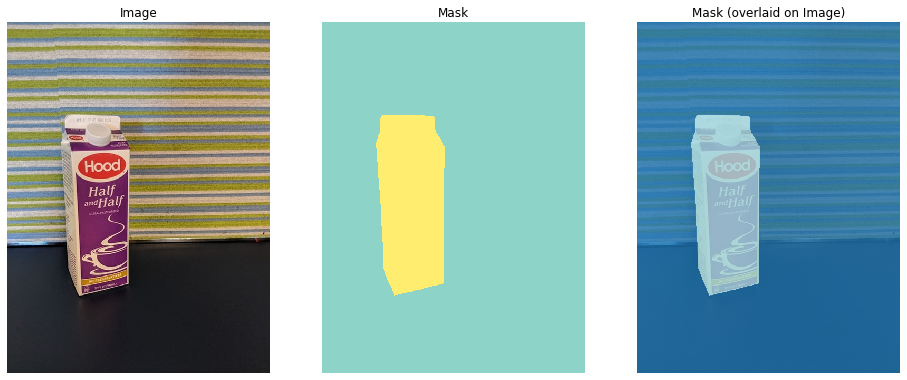

In [8]:
plot_image_and_mask(im_paths[0], mask_paths[0], alpha = 0.8)

# Load Images

For training and validation, we randomly split the data in an `8:2` ratio, holding 80% of the data for training and 20% for validation. One can also create dedicated train-test splits e.g. using fastai's `split_by_folder()` or `split_by_fname_file()` functions instead of `split_by_rand_pct()` below.

In [9]:
# Define function which, given as input a path to an image, returns the corresponding path to its mask
get_gt_filename = lambda x: anno_path/f'{x.stem}.png'

data = (
    SegmentationItemList.from_folder(im_path)
    # .split_by_fname_file('../valid.txt')
    .split_by_rand_pct(valid_pct=0.2, seed=10)
    .label_from_func(get_gt_filename, classes=classes)
    .transform(get_transforms(), size=IM_SIZE, tfm_y=True)
    .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
    .normalize(imagenet_stats)
)

Show the number of images in the training and validation set.

In [10]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: SegmentationItemList
Image (3, 133, 100),Image (3, 133, 100),Image (3, 133, 100),Image (3, 133, 100),Image (3, 133, 100)
y: SegmentationLabelList
ImageSegment (1, 133, 100),ImageSegment (1, 133, 100),ImageSegment (1, 133, 100),ImageSegment (1, 133, 100),ImageSegment (1, 133, 100)
Path: C:\Users\pabuehle\Desktop\computervision-recipes\data\segFridgeObjects\images;

Valid: LabelList (25 items)
x: SegmentationItemList
Image (3, 133, 100),Image (3, 133, 100),Image (3, 133, 100),Image (3, 133, 100),Image (3, 133, 100)
y: SegmentationLabelList
ImageSegment (1, 133, 100),ImageSegment (1, 133, 100),ImageSegment (1, 133, 100),ImageSegment (1, 133, 100),ImageSegment (1, 133, 100)
Path: C:\Users\pabuehle\Desktop\computervision-recipes\data\segFridgeObjects\images;

Test: None>

We examine some sample data using the `databunch` we created.

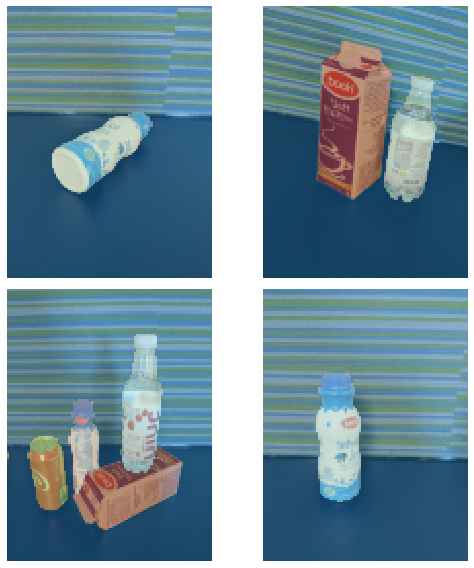

In [11]:
data.show_batch(rows=2)

Show all available classes:

In [12]:
print(f"Number of images: {len(data.y.items)}")
print(f"Classes: {data.classes}")

Number of images: 103
Classes: ['background', 'can', 'carton', 'milk_bottle', 'water_bottle']


And some more detailed information, ie. how many segments there are for each class, as well as the distribution of segment sizes in pixels. Note that because of e.g. occlusions a single object can be split into multiple segments, which is why in our dataset we see some segments with only very few pixels. 


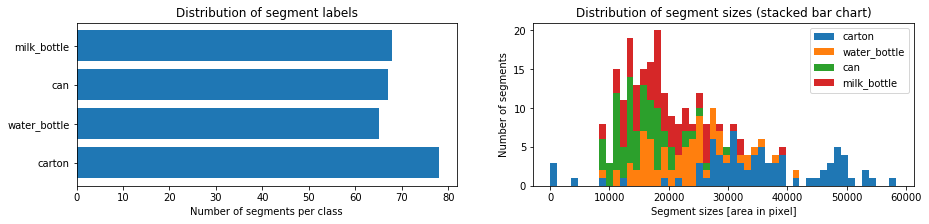

In [13]:
plot_mask_stats(data, classes, figsize=(15,3), exclude_classes = ['background'])

# Train a Model

As image segmentation model, we use a **UNet** CNN architecture with ResNet18 backbone which was pre-trained on [ImageNet](http://www.image-net.org/). For more details on the UNet model see [here](https://docs.fast.ai/vision.models.unet.html). 

We use fastai's `unet_learner` function to obtain a UNet object. The objective function to be maximised during training is specified via `metrics` as the ratio of correctly classified pixels.

In [14]:
learn = unet_learner(
    data, 
    ARCHITECTURE, 
    wd=1e-2, 
    metrics=get_objective_fct(classes)
)

First we only train the last layers of the to provide a rough initialization of the UNet model. 

epoch,train_loss,valid_loss,_objective_fct_partial,time
0,0.991858,0.426162,0.851856,00:21
1,0.718716,0.296569,0.887856,00:06
2,0.536226,0.190672,0.919356,00:05


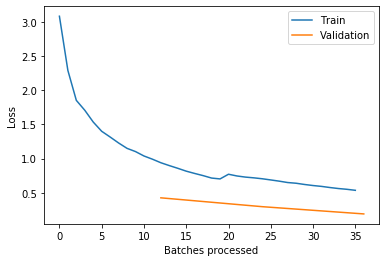

In [15]:
learn.fit_one_cycle(EPOCHS_HEAD, slice(LEARNING_RATE), pct_start=0.9)
learn.recorder.plot_losses()

Next, we train all the CNN layers by using the `unfreeze` method.

In [16]:
learn.unfreeze()

epoch,train_loss,valid_loss,_objective_fct_partial,time
0,0.205379,0.172474,0.925910,00:06
1,0.200579,0.160262,0.930307,00:06
2,0.194013,0.147139,0.937711,00:06
3,0.183392,0.122894,0.950316,00:06
4,0.170096,0.106943,0.955967,00:06
5,0.156135,0.088329,0.967883,00:06
6,0.145853,0.086819,0.968638,00:06
7,0.134904,0.070376,0.976950,00:06
8,0.120841,0.052884,0.981985,00:06
9,0.106660,0.052189,0.980638,00:06


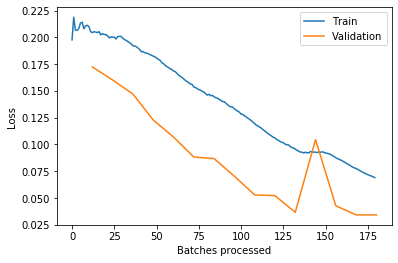

In [17]:
lrs = slice(LEARNING_RATE/400,LEARNING_RATE/4)
learn.fit_one_cycle(EPOCHS_FULL, lrs, pct_start=0.8)
learn.recorder.plot_losses()

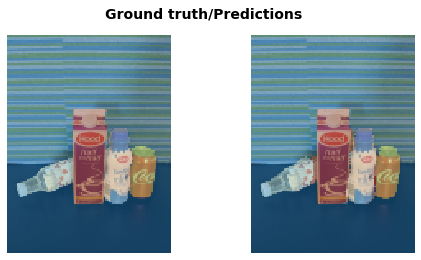

In [18]:
# Show results on the validation set using fastai's function
learn.show_results(rows=1)

In [19]:
# Save model
#learn.export("my_model")

# Validate the model

This section provides a quantitative analysis of the trained model using the validation set.

We report the overall accuracy (ie ratio of correctly classified pixels), as well as the accuracy for each class. 

In [20]:
cmat, cmat_norm = confusion_matrix(learn, data.valid_dl)
accs = print_accuracies(cmat, cmat_norm, classes)

Overall accuracy: 98.80%
Class-averaged accuracy: 96.39%
	Class      background has accuracy: 99.48%
	Class             can has accuracy: 97.30%
	Class          carton has accuracy: 92.02%
	Class     milk_bottle has accuracy: 97.41%
	Class    water_bottle has accuracy: 95.71%


More insights into the model performance can be obtained from the confusion matrix. A confusion matrix details the number of pixels which the model classified correctly. For each class, the matrix lists correct pixels along the diagonal, and incorrect ones off-diagonal. This allows a detailed look on how the model confused the prediction of some classes.

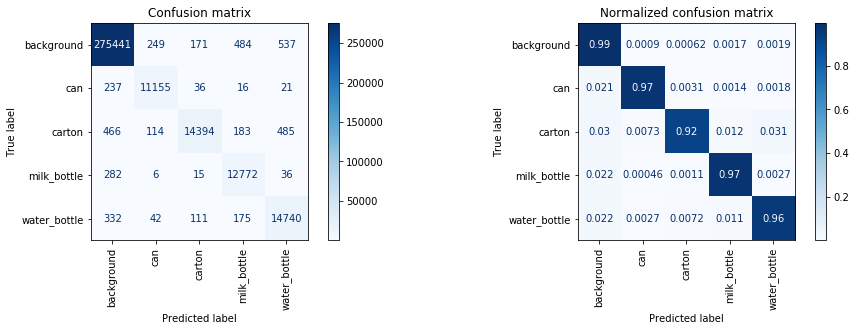

In [21]:
plot_confusion_matrix(cmat, cmat_norm, classes)

# Scoring

The `predict()` and `plot_segmentation()` functions can be used to run the model on given an image, and to visualize the results.

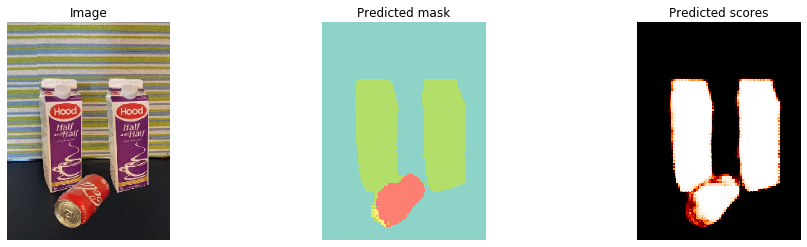

In [22]:
# Download an example image
IM_URL = "https://cvbp.blob.core.windows.net/public/images/cvbp_two_cartons.jpg"
im_path = "example.jpg"
urllib.request.urlretrieve(IM_URL, im_path)

# Run model inference
mask, scores = predict(im_path, learn, thres=0.2)

# Plot results
plot_segmentation(im_path, mask, scores)

In [23]:
# Count how many pixels are predicted to be a certain class
for i in range(mask.max()):
    print(f"Class {classes[i]} has {sum(sum(mask == i))} pixels")

Class background has 9415 pixels
Class can has 603 pixels
Class carton has 3247 pixels
Class milk_bottle has 1 pixels


In [24]:
# Preserve some of the notebook outputs
sb.glue("validation_overall_accuracy", accs[0])
sb.glue("validation_class_accuracies", list(accs[1]))

# Conclusion

Using the concepts introduced in this notebook, you can bring your own dataset and train a model to detect the per-pixel location of objects of interest for your specific setting. 